In [1]:
!nvidia-smi

Mon May  1 19:21:31 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
| 62%   51C    P5               44W / 390W|    236MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# (1) Import necessary libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import time
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

2023-05-02 02:42:08.716865: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 02:42:08.753994: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# (2) Download the datasets

### You can download the datasets from https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

In [5]:
!ls datasets/flickr30k_images

flickr30k_images  results.csv


# (3) Prepare the datasets

In [2]:
captioning_ds = pd.read_csv("datasets/flickr30k_images/results.csv", delimiter="|")
captioning_ds.columns = ["image_name", "comment_number", "comment"]

In [3]:
captioning_ds.head()

image_name comment_number   
0  1000092795.jpg              0  \
1  1000092795.jpg              1   
2  1000092795.jpg              2   
3  1000092795.jpg              3   
4  1000092795.jpg              4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .

All images have an equal number of captions, which is five (balanced).

In [4]:
image_name_value_count = captioning_ds.image_name.value_counts()
print("max:", max(image_name_value_count))
print("min:", min(image_name_value_count))

max: 5
min: 5


In [5]:
image_name_value_count

image_name
1000092795.jpg    5
459538095.jpg     5
459804826.jpg     5
459778335.jpg     5
4597303045.jpg    5
                 ..
3029715635.jpg    5
3029472296.jpg    5
3029463004.jpg    5
3029411230.jpg    5
998845445.jpg     5
Name: count, Length: 31783, dtype: int64

# (4) Multiple descriptions of an image will be combined into a single data point

In [6]:
# retrieve all distinct image names.
image_names = pd.unique(captioning_ds.image_name)

In [7]:
datasets_dict = {}

In [8]:
def _func(image_name):
    captions = ["[CLS] " + str(x) + " [SEP]" for x in captioning_ds[captioning_ds["image_name"] == image_name].comment.values]
    new_dict = {
        os.path.join("datasets/flickr30k_images/flickr30k_images", image_name): captions
    }
    datasets_dict.update(new_dict) 
    return ' ' . join(captions)

In [62]:
start_time = time.perf_counter()
print("Start processing ...")

captions_data = captioning_ds.image_name.apply(_func)

end_time = time.perf_counter()
print(f"Processing time: {end_time - start_time} seconds") # 1032.8136966410093 seconds

Start processing ...
Processing time: 1032.8136966410093 seconds


Show an example of the data

In [56]:
datasets_dict

{'datasets/flickr30k_images/flickr30k_images/1000092795.jpg': ['[CLS]  Two young guys with shaggy hair look at their hands while hanging out in the yard . [SEP]',
  '[CLS]  Two young , White males are outside near many bushes . [SEP]',
  '[CLS]  Two men in green shirts are standing in a yard . [SEP]',
  '[CLS]  A man in a blue shirt standing in a garden . [SEP]',
  '[CLS]  Two friends enjoy time spent together . [SEP]']}

For text vectorization (adapt)

In [202]:
captions_data

0         [CLS]  Two young guys with shaggy hair look at...
1         [CLS]  Two young guys with shaggy hair look at...
2         [CLS]  Two young guys with shaggy hair look at...
3         [CLS]  Two young guys with shaggy hair look at...
4         [CLS]  Two young guys with shaggy hair look at...
                                ...                        
158910    [CLS]  A man in shorts and a Hawaiian shirt le...
158911    [CLS]  A man in shorts and a Hawaiian shirt le...
158912    [CLS]  A man in shorts and a Hawaiian shirt le...
158913    [CLS]  A man in shorts and a Hawaiian shirt le...
158914    [CLS]  A man in shorts and a Hawaiian shirt le...
Name: image_name, Length: 158915, dtype: object

Store them for later use

In [9]:
class PickleDumpLoad(object): 
    def __init__(self):
        self.address = f'./'
        
    def save_config(self, obj, filename):  
        with open(os.path.join(self.address, filename), 'wb') as config_f:
            pickle.dump(obj, config_f, protocol=4) # PROTOCOL = 4 ALLOWING TO SAVE LARGE OBJECT   
         
    def load_config(self, filename):  
        with open(os.path.join(self.address, filename), 'rb') as f_in:
             obj = pickle.load(f_in)
        return obj  

In [65]:
PickleDumpLoad().save_config(datasets_dict, "datasets_dict.pickle")
PickleDumpLoad().save_config(captions_data, "captions_data.pickle")

Load the dataset dictionary from a file

In [10]:
datasets_dict = PickleDumpLoad().load_config("datasets_dict.pickle")
captions_data = PickleDumpLoad().load_config("captions_data.pickle")

Show some sample images

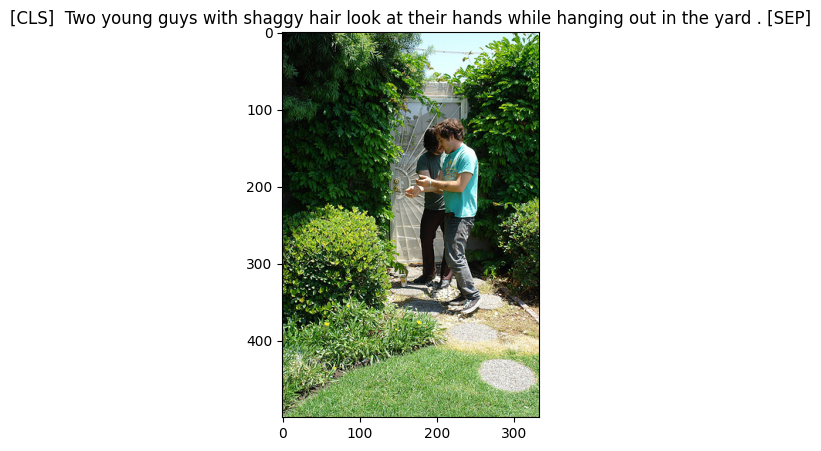

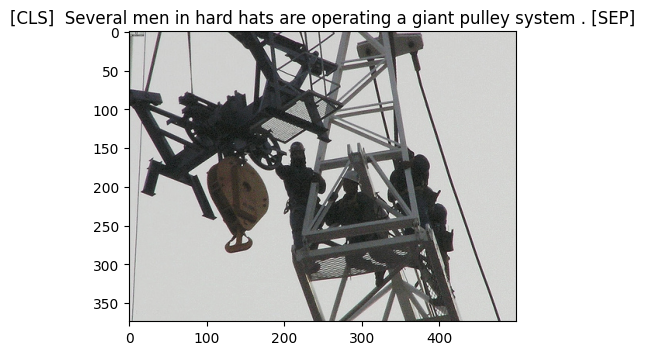

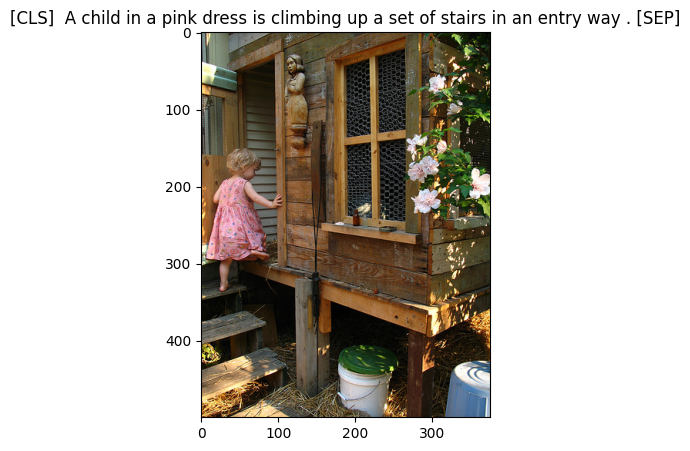

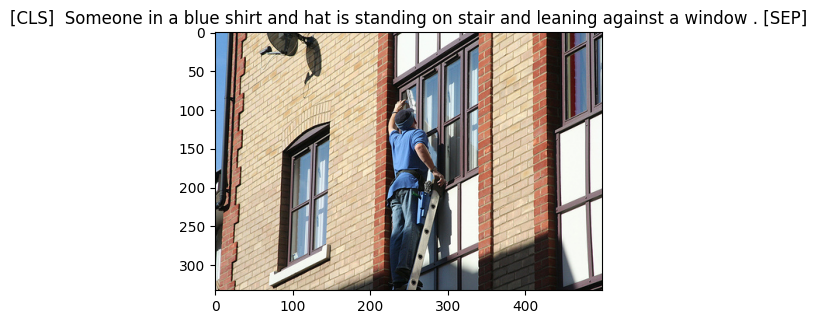

In [205]:
count = 0
for key, val in datasets_dict.items():
    
    img = mpimg.imread(key)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(val[0])
        
    if count == 3: 
        break
        
    count += 1

# (5) Create tokenizers

In [11]:
VOCAB_SIZE = 20000
SEQ_LENGTH = 25

In [12]:
vectorization = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=lambda text: tf.strings.regex_replace(tf.strings.lower(text), "[^a-z]+", " "),
)

2023-05-02 02:42:36.140251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22007 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [71]:
start_time = time.perf_counter()
print("Start processing ...")

vectorization.adapt(captions_data.values, batch_size=32)

end_time = time.perf_counter()
print(f"Processing time: {end_time - start_time} seconds") # 19.115352042019367 seconds

Start processing ...
Processing time: 19.115352042019367 seconds


Save the vocabularies

In [208]:
vocabularies = vectorization.get_vocabulary()

In [74]:
with open('vocabulary.txt', 'w') as f:
    for word in vocabularies:
        f.write(word + '\n')

Load the vocabularies

In [13]:
vocabularies = None
with open('vocabulary.txt', 'r') as f:
    vocabularies = [line.strip() for line in f.readlines()] 

Set the vocabularies

In [14]:
vectorization.set_vocabulary(vocabularies)

Test the vectorization

In [15]:
vectorization(["I love you"])

<tf.Tensor: shape=(1, 25), dtype=int64, numpy=
array([[1217, 2219, 1172,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]])>

# (6) Create an image loader

In [16]:
IMG_SIZE = (224, 224)

In [17]:
def image_loader(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

# (7) Create the datasets

In [18]:
PERCENTAGE = .8
TOTAL_SAMPLES = len(list(datasets_dict.keys())) 
TRAIN = int(TOTAL_SAMPLES * PERCENTAGE)
TEST = TOTAL_SAMPLES - TRAIN
TRAIN, TEST

(25426, 6357)

In [19]:
train_tf = tf.data.Dataset.from_tensor_slices((list(datasets_dict.keys())[:TRAIN], list(datasets_dict.values())[:TRAIN]))
test_tf = tf.data.Dataset.from_tensor_slices((list(datasets_dict.keys())[-TEST:], list(datasets_dict.values())[-TEST:]))

In [20]:
def create_ds(img_path, captions):
    return image_loader(img_path), vectorization(captions)

In [21]:
BATCH_SIZE = 32

In [22]:
train = train_tf.map(create_ds, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()
test = test_tf.map(create_ds, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()

# (8) Build the model

Create an encoder with transormer

In [23]:
def get_cnn_model():
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(
        input_shape=(*IMG_SIZE, 3), include_top=False, weights="imagenet",
    ) 
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = tf.keras.layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = tf.keras.models.Model(base_model.input, base_model_out)
    return cnn_model

In [24]:
class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.dense_1 = tf.keras.layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1

In [25]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

Create the decoder

In [26]:
class TransformerDecoderBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = tf.keras.layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = tf.keras.layers.Dense(embed_dim)

        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.layernorm_3 = tf.keras.layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = tf.keras.layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = tf.keras.layers.Dropout(0.3)
        self.dropout_2 = tf.keras.layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        
        return preds
    
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

Build the image captioning model

In [27]:
class ImageCaptioningModel(tf.keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super(ImageCaptioningModel, self).__init__()
        
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker = tf.keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug 

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1] 
        batch_seq_true = batch_seq[:, 1:]
         
        
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)
 
        img_embed = self.cnn_model(batch_img)
 
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )
 
                batch_loss += loss
                batch_acc += acc
 
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )
 
            grads = tape.gradient(loss, train_vars)
 
            self.optimizer.apply_gradients(zip(grads, train_vars))
 
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
 
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0
 
        img_embed = self.cnn_model(batch_img)
 
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )
 
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)
 
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)
 
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}
    
    @property
    def metrics(self): 
        return [self.loss_tracker, self.acc_tracker]

In [28]:
EMBED_DIM = 512
FF_DIM = 512
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)

image_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(0.3),
    ]
)

caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

# (9) Prepare the model for training

In [29]:
EPOCHS = 200

In [30]:
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps, **kwargs):
        super(LRSchedule, self).__init__(**kwargs)
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )
    
num_train_steps = len(train) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

In [31]:
class ModelCheckpointCustom(tf.keras.callbacks.Callback):
    
    def __init__(self, model_path, save_best_only=False):
        super(ModelCheckpointCustom, self).__init__()
         
        self.model_path = model_path
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf') 

    def on_epoch_end(self, epoch, logs=None):
        
        print('\rlogs: ', logs, '\r')
        
        current_val_loss = 0 if logs['loss'] is None else logs['loss']
        
        print('\rcurrent_val_loss: ', current_val_loss, '\r')
        print('\rsave_best_only: ', self.save_best_only, '\r')
        print('\rbest_val_loss: ', self.best_val_loss, '\r')
        print('\rcurrent_val_loss < best_val_loss: ', current_val_loss < self.best_val_loss, '\r') 
        
        if self.save_best_only and current_val_loss < self.best_val_loss:
            print('\rSaving weights at (save_best_only=True): ', self.model_path, '\r')
            self.best_val_loss = current_val_loss 
            
            PickleDumpLoad().save_config(self.model.weights, self.model_path)
            # self.model.save_weights(self.model_path)
            print("\rModel has been saved!")
        else:
            print('\rSaving weights at (save_best_only=False): ', self.model_path, '\r')
            
            PickleDumpLoad().save_config(self.model.weights, self.model_path)
            # self.model.save_weights(self.model_path) 
            print("\rModel has been saved!")

save_callbacks = ModelCheckpointCustom(model_path='caption_model_weights.new.weights', save_best_only=True)

In [32]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=7, start_from_epoch=0)

In [33]:
caption_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False, reduction="none"
    ),
    optimizer=tf.keras.optimizers.Adam(lr_schedule)
)

# (10) Train the model

In [37]:
history = caption_model.fit(
    train,
    epochs=1,
    validation_data=test,
    callbacks=[early_stopping, save_callbacks],
)

logs:  {'loss': 8.804691314697266, 'acc': 0.579550564289093, 'val_loss': 20.45661163330078, 'val_acc': 0.3567885458469391} 
current_val_loss:  8.804691314697266 
save_best_only:  True 
best_val_loss:  inf 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  caption_model_weights.new.weights 
Model has been saved!
795/795 [==============================] - 136s 170ms/step - loss: 8.8047 - acc: 0.5803 - val_loss: 20.4566 - val_acc: 0.3568


In [56]:
PickleDumpLoad().save_config(caption_model.weights, "caption_model_weights.new.weights")

# (11) Load the model

In [35]:
caption_model_weights_loaded = PickleDumpLoad().load_config("caption_model_weights.new.weights")

In [36]:
caption_model.set_weights(caption_model_weights_loaded)

# (12) Test the model

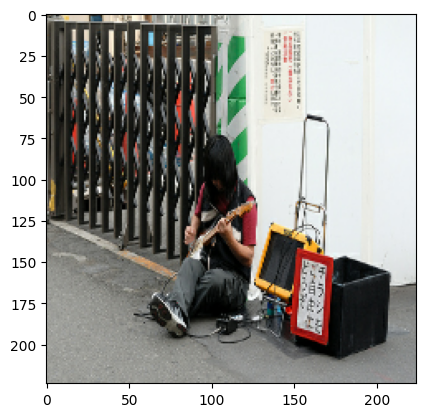

Predicted Caption:  a man playing an electric guitar on the street a woman in a black shirt and jeans and a black shirt is sitting


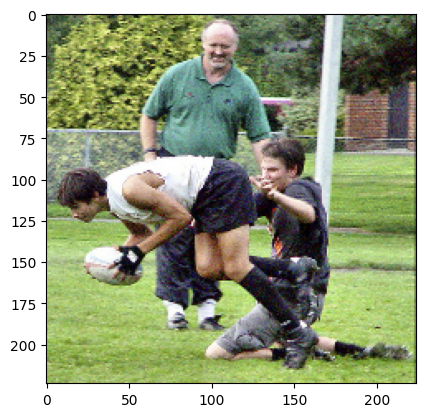

Predicted Caption:  a man in a green shirt and a man in a black shirt and a woman in a green shirt are playing a game


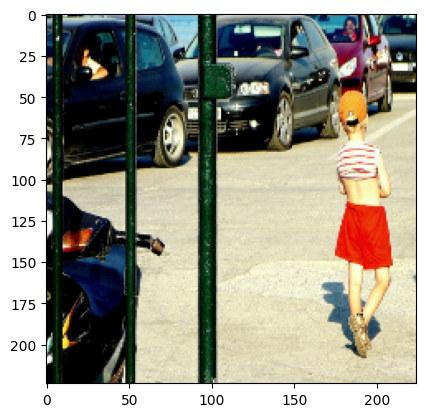

Predicted Caption:  a little girl in a red dress is walking down the street a black and white dress a black hat with


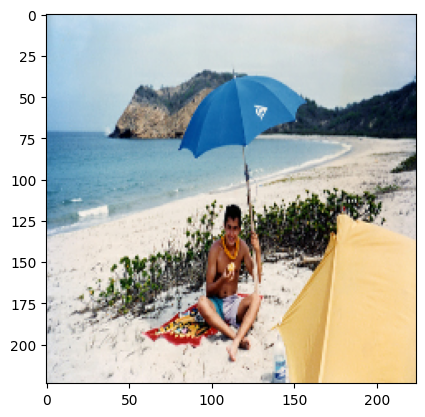

Predicted Caption:  a man is sitting on the beach with a blue umbrella a man in a blue shirt and a woman in a red


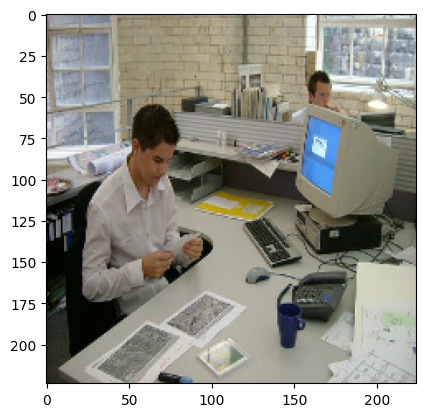

Predicted Caption:  a man in a white shirt is sitting at a desk with a computer a desk a large screen behind him


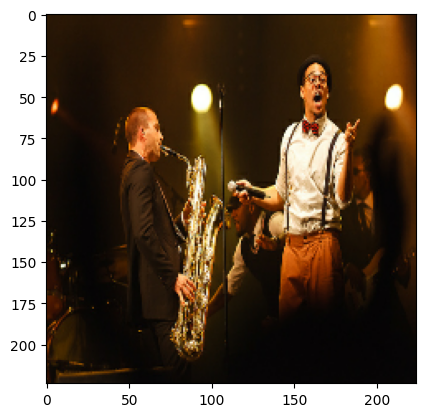

Predicted Caption:  a man in a suit is playing a saxophone a trumpet a band trumpet player and a black shirt a


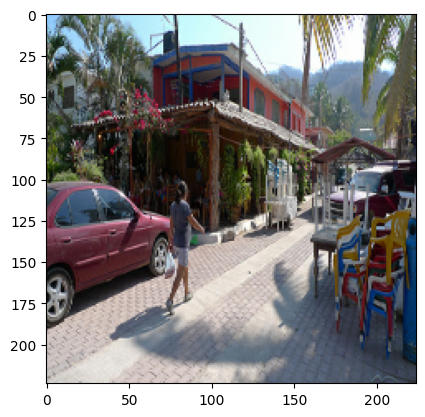

Predicted Caption:  a man in a red shirt is walking down a street parked car the street a man in a red shirt


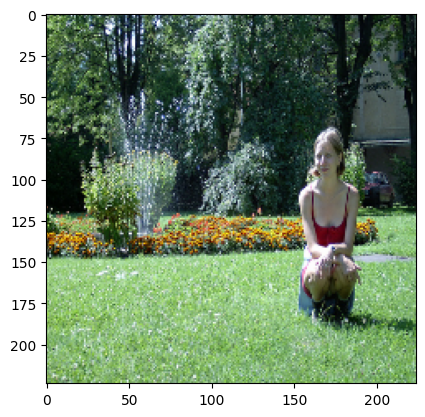

Predicted Caption:  a man and a woman are sitting in the grass a garden in the background a man is bending down with a


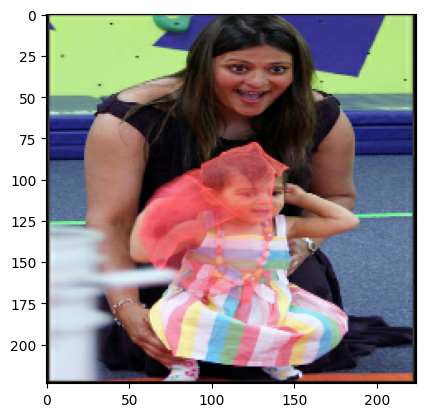

Predicted Caption:  a girl in a pink shirt is holding a tray of food on her head hand hand a little girl


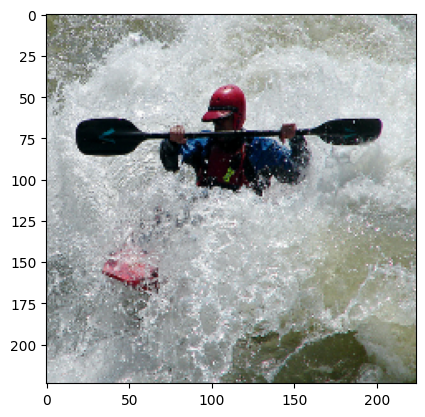

Predicted Caption:  a man with a red hat is kayaking in rough water river wild a big wave blue and catches


In [38]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(datasets_dict.keys())

for x in range(10): 
    
    sample_img = np.random.choice(valid_images)
 
    sample_img = image_loader(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()
 
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)
 
    encoded_img = caption_model.encoder(img, training=False)
 
    decoded_caption = "cls "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
          
        sampled_token = index_lookup[sampled_token_index]
            
        if sampled_token == " sep":
            break
            
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("cls ", "")
    decoded_caption = decoded_caption.replace(" sep", "").strip()
    
    print("Predicted Caption: ", decoded_caption)

  